In [1]:
from copy import deepcopy
from collections import defaultdict
import random
import numpy as np
import time 
import json
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import papermill as pm
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

## Reading and initializing functions

In [2]:
def get_sudokus(filename, sudokusize=9):
    '''
    get_states is to read multiple sudokus in the format:
    ..8..4..5...64..5 etc.
    returns a list of sudoku board states as clauses in a dict
    '''
    sudokus = []
    with open(filename) as sudoku_states:
        for i, state in enumerate(sudoku_states):
            sudoku = {}
            pointers = {}
            row = 1
            index = 0
            for j, content in enumerate(state):
                if j%sudokusize == 0 and j > 0:
                    row+=1
                try:
                    int(content)
                    literal = int(str(row) + str(j%sudokusize+1) + content)
                    sudoku[index] = [literal]
                    if literal not in pointers.keys():
                        pointers[literal] = [index]
                    else:
                        pointers[literal].append(index)
                    index += 1
                except:
                    # is not convertible to int
                    continue
            sudokus.append((sudoku, pointers))
    return sudokus

def get_constraints_from_dimacs(filename, prevConstraints={}, prevPointers={}):
    '''
    Convert dimacs file to a dictionary of constraints
    and pointers. Allows merging with previous pointers and constraints.
    '''
    constraints = prevConstraints # dictionary with constraints as: clausenumber->[literals]
    pointers = prevPointers # dictionary with pointers to clause numbers for literals as: literals->[clausenumbers]
    initial_length = len(constraints)
    with open(filename) as f:
        for i, clause in enumerate(f):
            index = i + initial_length
            if clause[0] == 'c' or clause[0] == 'p':
                # skip comments etc.
                continue
            constraints[index]= []
            for literal in clause.split():
                literal = int(literal)
                if literal != 0:
                    constraints[index].append(literal)
                    if literal not in pointers.keys():
                        pointers[literal] = [index]
                    else:
                        pointers[literal].append(index)
                    
    return constraints, pointers

    

## DP helper functions for constraints updates

In [3]:
def assign_literal(constraints, pointers, literal, assignments):
    '''
    assign the given literal to be True.
    assign_literal is aimed to be one recursion stack, so deepcopies are made
    in order to properly backtrack
    '''
    constraintsCopied = deepcopy(constraints)
    pointersCopied = deepcopy(pointers)
    assignmentsCopied = deepcopy(assignments)
    assignmentsUpdated = update_assigments(assignmentsCopied, literal)
    constraintsUpdated, pointersUpdated = update_constraints(constraintsCopied, pointersCopied, literal)
    return constraintsUpdated, pointersUpdated, assignmentsUpdated
     
def update_constraints(constraints, pointers, literal):
    '''
    literal: e.g. 112 or 112'
    Updates constraints and pointers by removing all clauses 
    with the given literal, because the clause becomes true.
    Remove counter-literal out of all clauses.
    '''
    ## Find clauses with literal and remove them
    
    for lit in literal:
        clauses=list(pointers[lit])
        for clause in clauses:
            for l in constraints[clause]:
                pointers[l].remove(clause)
                if len(pointers[l])==0 and l!=lit:
                    del pointers[l]
            del constraints[clause]
        del pointers[lit]
    
    ## Find clauses with counter-literal and remove its counter-literal
    
    for lit in literal:
        counterLiteral = -lit
        if counterLiteral in pointers.keys():
            counters=list(pointers[counterLiteral])
            for clause in counters:
                constraints[clause].remove(counterLiteral)
            del pointers[counterLiteral]
        else:
            continue
   
    return constraints, pointers

def update_assigments(assignments, literal):
    '''
    Keep track of assigned literals.
    Needed in order to return satisfiable solution of literals.
    '''
    for lit in literal:
        if lit in assignments:
            print("already assigned", lit, "(in this stack), returning...")
            return []
        else:
            assignments.append(lit)
    return assignments

def check_tautologies(constraints, pointers):
    '''
    Check for clauses with a tautology and remove
    them.
    '''
    assignments = []
    foundOne = False
    for clause in constraints.keys():
        literals = constraints[clause]
        counterLiterals = [-x for x in literals]
        for i in literals:
            for j in counterLiterals:
                if i == j:
                    del constraints[clause]
                    pointers[i].remove(clause)
                    pointers[-i].remove(clause)
                    foundOne = True
                    assigments.append(i)
                    break
    if foundOne:
        print("Found tautologies and removed corresponding clauses")
    else:
        print("No tautologies found")
                  
    return constraints, pointers, assignments  

### Extract features to use as classifier datapoints

In [5]:
def extract_features(literals, constraints, pointers, assignments, logging=True):
    """
    Extract features is used to extract the decision features of a literal 
    on a particular moment/location in the search tree. If logging is turned on, the features are saved 
    in a global dict to later form a training set, else a feature row is returned for live prediction.
    """
    
    literal = next(iter(literals))
    ## Look one step ahead
    constraintsNew, pointersNew, assignmentsNew = assign_literal(constraints, pointers, literals, assignments)
    
    ## Ratio of the polarity of this literal before assignment
    positive = len(pointers[literal])
    negative = len(pointers[-literal])
    total = positive+negative
    if total != 0:
        ratio = positive/(positive+negative)
    else:
        ratio = 0
    
    # Clauses that were resolved with this assignment
    clausesResolved = len(constraints) - len(constraintsNew)
    
    # Clauses that became empty with this assignment
    emptyClauses = 0
    for clause in constraintsNew.keys():
        if not constraintsNew[clause]:
            emptyClauses += 1
    
    ## Average clause length with given literal before assignment
    clauses = pointers[literal]
    lengths = [len(constraints[c]) for c in clauses]
    if len(lengths) != 0:
        mean = np.mean(lengths) 
    else:
        mean = 0
        
    _, momScores = mom(constraints, pointers, 1, [literal])
    
    _, jerowScores = jeroSloWang(constraints, pointers, [literal])
    
    if logging:
        global features
        features[literal] = {}
        features[literal]["posneg_ratio"] = ratio
        features[literal]["c_res"] = clausesResolved
        features[literal]["empty_c"] = emptyClauses  
        features[literal]["c_len"] = mean
        features[literal]["SAT"] = 0
        features[literal]["mom"] = next(iter(momScores))
        features[literal]["jerow"] = next(iter(jerowScores))
    else:
        return norm([ratio, clausesResolved, emptyClauses, mean, next(iter(momScores)), next(iter(jerowScores))])
    
def norm(X):
    newX=[]
    newX.append((X[0]-maxmin['posneg_ratio'][1])/(maxmin['posneg_ratio'][0]-maxmin['posneg_ratio'][1]))
    newX.append((X[1]-maxmin['c_res'][1])/(maxmin['c_res'][0]-maxmin['c_res'][1]))
    newX.append(X[2])
    newX.append((X[3]-maxmin['c_len'][1])/(maxmin['c_len'][0]-maxmin['c_len'][1]))
    newX.append((X[4]-maxmin['mom'][1])/(maxmin['mom'][0]-maxmin['mom'][1]))
    newX.append((X[5]-maxmin['jerow'][1])/(maxmin['jerow'][0]-maxmin['jerow'][1]))
    return newX

def has_no_duplicates(l):
    return len(set(l))==len(l)

### Train classifier

In [6]:
def train(file=None):
    print("Training logistic regression classifier...")
    df=pd.read_json(file)
#     print(df.keys())
    df=df[['SAT','posneg_ratio','c_res','empty_c','c_len','mom','jerow']]
    global maxmin
    maxmin={}
    for col in df.keys():
        maxmin[col]=(max(df[col]),min(df[col]))
    toNorm=list(df.keys())
    toNorm.remove('SAT')
    toNorm.remove('empty_c')
    for col in toNorm:
        df[col]=df[col].apply(lambda x:(x-maxmin[col][1])/(maxmin[col][0]-maxmin[col][1]))
    trainKeys=list(df.keys())
    trainKeys.remove('SAT')
    X = df[trainKeys]
    y = df['SAT']
    global regressor
    regressor = LogisticRegression().fit(np.array(X), np.array(y))

## DP cases

In [7]:
def empty_clause(constraints):
    for clause in constraints.keys():
        if not constraints[clause]:
            return True
        
    return False

def unit_clause(constraints): 
    units=[]
    negUnit=[]
    for clause in constraints.keys():
        if len(constraints[clause])==1:
            literal = constraints[clause][0]
            if literal>0:
                units.append(literal)
            else:
                negUnit.append(literal)
    if len(units)>0:
        return list(set(units))
    else:
        return list(set(negUnit))

def unit_propagate(constraints, pointers, assignments):
    '''
    Automatically assign the literal of all unit clauses
    until there are no unit clauses left.
    '''
    literals = unit_clause(constraints)
    if len(literals)>0:
        status=True
        constraints, pointers, assignments = assign_literal(constraints, pointers, literals, assignments)    
    else:
        status=False
    
    return constraints, pointers, assignments,status

def pure_literal(pointers):
    literals=list(pointers.keys())
    for literal in literals:
        if -literal not in literals:
            return [literal],True
        
    return None,False

def random_literal(pointers):
    literals=list(pointers.keys())  
    try:
        literal = random.choice(literals) 
    except:
        return []
    
    return [literal]

### Branch split heuristics

In [8]:
def logreg(constraints, pointers, assignments, b=5): 
    """
    Logreg performs a prediction on a batch of literals and picks the highest scoring literal.
    """
    if(len(pointers.keys()) < b):
        b = len(pointers.keys())
    if len(pointers.keys())==0:
        return []
    batch = random.sample(list(pointers.keys()), k=b)
    X = np.array([extract_features([literal], constraints, pointers, assignments, logging=False) for literal in batch])
    
    scores = regressor.predict(X) # globally available regressor
    literal = batch[np.argmax(scores)]
    return [literal]
    
#Mom's heuristic    
def mom(constraints, pointers, k, batch=False):
    momScores = []
    smallestClasses=[]
    minClass=np.inf
    for clause in constraints.keys():
        if len(constraints[clause])<minClass:
            minClass=len(constraints[clause])
            smallestClasses=[]
            smallestClasses.append(clause)
        elif len(constraints[clause])==minClass:
            smallestClasses.append(clause)
    value=0
    maxLiteral=None
    haveSeen=[]
    
    if batch:
        b = batch
    else:
        b = pointers.keys()
    
    for literal in b:
        if literal not in haveSeen and -literal not in haveSeen:
            X=len([x for x in pointers[literal] if x in smallestClasses])
            X_=len([x for x in pointers[-literal] if x in smallestClasses])
            momsValue=(X+X_)*2^k+(X*X_)
            momScores.append(momsValue)
            haveSeen.append(literal)
            if momsValue>value:
                value=momsValue
                maxLiteral=literal
    if maxLiteral:
        return [maxLiteral], momScores
    else:
        return [], momScores
    
#jeroslow wang heuristic
def jeroSloWang(constraints, pointers, batch=False):
    j={}
    maxValue=0
    maxLiteral=None
    if len(pointers.keys())==0:
        return []
    
    if batch:
        b = batch
    else:
        b = pointers.keys()
    
    for literal in b:
        for clause in pointers[literal]:
            if literal not in j.keys():
                j[literal]=0
            j[literal]+=(2**(-len(constraints[clause])))
       
        if j[literal]>maxValue:
            maxValue=j[literal]
            maxLiteral=literal
            
    return [maxLiteral], [j[literal] for literal in b]
 

## DP main function

In [11]:
def DP(constraints, pointers, assignments, split):
    """
    DP main recursive function. Always returns satisfiable
    assignment for all constraints if there is one.
    """
    status=True
    while status:
        constraints, pointers, assignments,status = unit_propagate(constraints, pointers, assignments)
        
    status=True
    while status:
        literal,status = pure_literal(pointers)
        if status:
            constraints, pointers, assignments = assign_literal(constraints, pointers, literal, assignments)
    
    if len(constraints.keys())==0:
        return assignments
   
    if empty_clause(constraints):
        return [] 
    
    global assignmentCount
    assignmentCount += 1
        
    if split=="random":
        literal = random_literal(pointers)
#         extract_features(literal, constraints, pointers, assignments, logging=True)
        if not literal:
            return DP(constraints, pointers, assignments, split)
    if split=="jerow":
        literal, scores = jeroSloWang(constraints,pointers)
        if not literal:
            return DP(constraints, pointers, assignments, split)
    if split=="moms":
        literal, scores = mom(constraints, pointers, 1)
        if not literal:
            return DP(constraints, pointers, assignments, split)
    if split=="logreg":
        literal = logreg(constraints, pointers, assignments, 10)
        if not literal:
            return DP(constraints, pointers, assignments, split)    
    
    constraintsUpdated, pointersUpdated, assignmentsUpdated = assign_literal(constraints, pointers, literal, assignments)
    flipped[len(assignmentsUpdated)].append(next(iter(literal)))
    assignmentsFinal = DP(constraintsUpdated, pointersUpdated, assignmentsUpdated, split)
    if assignmentsFinal:
        return assignmentsFinal
    not_looping = True
    if assignmentCount > 1000: # for efficiency
        not_looping = has_no_duplicates(flipped[(len(assignmentsUpdated))])
    elif not_looping:
        flipped[len(assignmentsUpdated)].append(-next(iter(literal))*-1)
        constraints, pointers, assignments = assign_literal(constraints, pointers, [-next(iter(literal))], assignments)
        return DP(constraints, pointers, assignments,split)
    else:
        return []

### Script

In [17]:
def solve(infile, split):
    """
    Solve expects an @infile with all constraints together. 
    In case of a sudoku: the initial board state + rules in one file.
    @split is the string name of the split heuristic.
    """
    if split=="logreg":
        train('final data to train.json')
    
    print("Reading and analyzing...")
    constraints, pointers = get_constraints_from_dimacs(infile)
    constraints, pointers, assignments = check_tautologies(constraints, pointers)
    
    global flipped
    flipped = defaultdict(list)
    
    global assignmentCount
    assignmentCount = 0
    
    print("Starting DP algorithm with "+ split + " splits...")
    assignments = DP(constraints, pointers, assignments, split)
    if assignments:
        print("Solution found")
        boardPositions = [a for a in assignments if a > 0]
        pm.record("solution", boardPositions)
    else:
        print("No solution found") 
        pm.record("solution", [])

def solve_many(problems, splits):
    """
    Solve_many was used to run on multiple sudokus with different heuristics
    recording the statistics along the way.
    """
    
    global flipped
    flipped = defaultdict(list)
    
    datapoints = []
    
    run_statistics = {}
    if "logreg" in splits:
        train('final data to train.json')
    for r in range(0, 1):
        for i, problem in enumerate(problems):
            print("problem", i)
            run_statistics[i] = {}
            for h in heuristics:
                run_statistics[i][h] = {}
                ## Get board and rules
                print("Reading and analyzing...")
                constraints, pointers = problem
                constraints, pointers = get_constraints_from_dimacs('sudoku-rules.txt', constraints, pointers)
                constraints, pointers, assignments = check_tautologies(constraints, pointers)

                print("Starting DP algorithm with "+ h + " splits...")
                global assignmentCount
                assignmentCount = 0
                global features
                features = {}
                startTime = time.time()
                assignments = DP(constraints, pointers, assignments, split=h)
                endTime = time.time()
                if assignments:
                    print("Solution found")
                    print("Time to complete:", "%2f seconds"%(endTime-startTime))
                    boardPositions = [a for a in assignments if a > 0]
                    print(np.reshape([int(str(pos)[2]) for pos in sorted(boardPositions)], (9,9)))
                    print("Branch split choices made:", assignmentCount)
                    run_statistics[i][h]["assignmentCount"] = assignmentCount
                    run_statistics[i][h]["runTime"] = (endTime-startTime)
                    for a in assignments:
                        if a in features.keys():
                            features[a]["SAT"] = 1
                    for f in features.keys():
                        datapoints.append(features[f])
                else:
                    print("No solution found")

    if datapoints:                
        with open('data.json', 'w') as outfile:
            json.dump(datapoints, outfile)

    with open('run_statistics.json', 'w') as f:
        json.dump(run_statistics, f)

# sudokusHard = get_sudokus('damnhard.sdk.txt')
# sudokus1000 = get_sudokus('1000 sudokus.txt')
# train_sudokus = [sudokus1000[x] for x in range(0,len(sudokus1000)) if x%2 == 0]
# test_sudokus = [sudokus1000[x] for x in range(0,len(sudokus1000)) if x%2 == 1]
# heuristics = ["random", "logreg"]
# solve_many(test_sudokus[-2:], heuristics)

### Visualizing results

In [28]:
dataTable={}
def analyze_run(file):
    average_time = {}
    average_assignments = {}
    with open(file) as f:
        runs = json.load(f)
        for run in runs.keys():
            for sudoku in runs[run].keys():
                for heuristic in runs[run][sudoku].keys():
                    if heuristic not in average_time.keys():
                        average_time[heuristic] = []
                    if heuristic not in average_assignments.keys():
                        average_assignments[heuristic] = []
                    average_time[heuristic].append(runs[run][sudoku][heuristic]["runTime"])
                    average_assignments[heuristic].append(runs[run][sudoku][heuristic]["assignmentCount"])
    for h in average_time.keys():
        dataTable[file.split('.')[0]+' time']=average_time[h][0:500]
        dataTable[file.split('.')[0]+' assignments']=average_assignments[h][0:500]

analyze_run('final output moms.json')
analyze_run('final output random.json')
analyze_run('final output jerow.json')
analyze_run('final output log reg.json')
df=pd.DataFrame(dataTable)
num=['i'+str(x) for x in range(len(df))]
df['instance']=num
df[df['final output random assignments']>=0].describe()

,final output moms time,final output moms assignments,final output random time,final output random assignments,final output jerow time,final output jerow assignments,final output log reg time,final output log reg assignments
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.906449,10.584000,0.894273,6.614000,6.088390,14.088000,0.753220,6.650000
std,3.420125,19.794712,1.020970,10.129275,8.653103,20.415333,0.847752,9.133583
min,0.282849,0.000000,0.180475,0.000000,0.905814,0.000000,0.167338,0.000000
25%,0.530151,1.000000,0.410106,1.000000,1.401275,2.000000,0.265733,1.000000
50%,0.937660,5.000000,0.566657,4.000000,2.807046,7.000000,0.447593,3.000000
75%,2.159487,13.000000,0.967610,9.000000,6.709601,18.000000,0.817796,9.000000
max,47.739417,252.000000,10.754009,104.000000,59.048210,129.000000,6.287461,65.000000


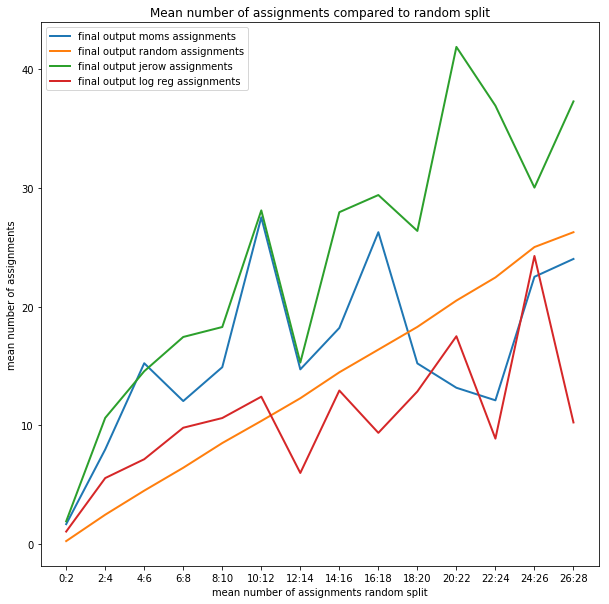

In [29]:
bins={}
for i in range(14):
    if len(bins.keys())==0:
        bins[str(0)+':'+str((i+1)*2)]=df[(df['final output random assignments']>=0) & (df['final output random assignments']<1*(i+1)*2)]['instance']
    else:
        bins[str(i*2)+':'+str((i+1)*2)]=df[(df['final output random assignments']>=2*i) & (df['final output random assignments']<1*(i+1)*2)]['instance']

columns=['final output moms assignments',
       'final output random assignments', 
       'final output jerow assignments',
       'final output log reg assignments']

fig, ax = plt.subplots(1,figsize=(10, 10))

for col in columns:#['output random assignments']:#columns:
    x=[]
    y=[]
    e=[]
    for bina in bins.keys():
        x.append(bina)
        y.append(np.mean(df[df['instance'].isin(bins[bina])][col]))
        e.append((np.std(df[df['instance'].isin(bins[bina])][col])))
        
# plot it!
    upperbound=[y[i]+e[i] for i in range(len(y))]
    lowerbound=[y[i]-e[i] for i in range(len(y))]
    ax.plot(x, y, lw=2, label=col)

    ax.set_title("Mean number of assignments compared to random split")
    ax.legend(loc='upper left')
    ax.set_xlabel('mean number of assignments random split')
    ax.set_ylabel('mean number of assignments')
plt.show()

### Solve constraint problem based on command line input

In [16]:
## This cell is reserved for saving command line arguments

In [ ]:
solve(infile, heuristic)